# Citi Surprise Index Backtest

This notebook will look at trading the DB G10 index using raw index values of the Citi Surprise Index

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FXCarryEconomicSurprise/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FXCarryCitiSurprise\root\src")
from FXCarryDataCollect import FXData

## Prep Data

In [3]:
def _lag_val(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.sort_values(
        "date").
        assign(lag_value = lambda x: x.value.shift()).
        dropna())

    return df_out

def get_citi() -> pd.DataFrame: 

    keep_cols = [
        "Citi Economic Surprise Index - Major Economies",
        "Citi Economic Surprise - United States",
        "Citi Economic Surprise Index - Major Economies Fixed Weight"]
    
    df_citi = (pd.read_excel(
        io = FXData().bbg_ticker_path).
        assign(Security = lambda x: x.Security.str.split(" ").str[0]).
        rename(columns = {
            "Security"   : "security",
            "Description": "desc"})
        [["security", "desc"]].
        merge(right = FXData().get_citi_suprise(), how = "inner", on = ["security"]).
        query("desc == @keep_cols").
        assign(desc = lambda x: x.desc.str.split("-").str[-1].str.replace("Major Economies", "G10")).
        groupby("security").
        apply(_lag_val).
        reset_index(drop = True))

    return df_citi

df_citi = get_citi()

In [4]:
def carry_index() -> pd.DataFrame: 
    
    tickers = ["FXCARRSP"]
    df_rtn  = (FXData().get_misc_indices().query(
        "security == @tickers").
        set_index("date")
        [["rtn"]])

    return df_rtn

df_carry = carry_index()

## Generate Portfolios

In [5]:
def get_signal_rtn(df_citi: pd.DataFrame, df_carry: pd.DataFrame) -> pd.DataFrame: 

    df_signal = (df_citi.merge(
        right = df_carry, how = "inner", on = ["date"]).
        assign(signal_rtn = lambda x: np.sign(x.lag_value) * x.rtn)
        [["desc", "date", "signal_rtn"]])

    return df_signal

df_signal = get_signal_rtn(df_citi, df_carry)

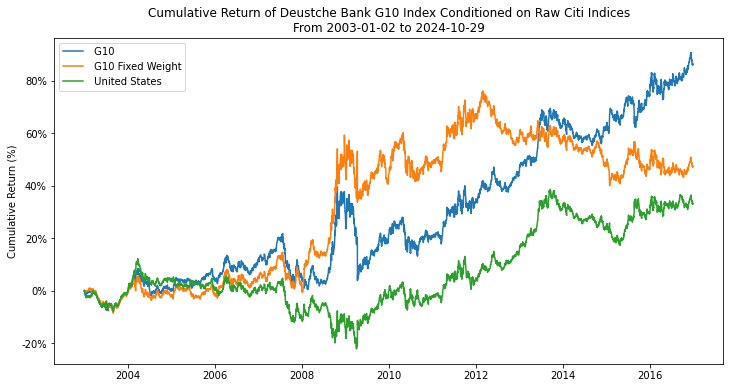

In [6]:
def plot_returns(df_signal: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (12,6))
    
    (df_signal.rename(
        columns = {"desc": ""}).
        pivot(index = "date", columns = "", values = "signal_rtn").
        fillna(0).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax      = axes,
            xlabel  = "",
            ylabel  = "Cumulative Return (%)",
            title   = "Cumulative Return of Deustche Bank G10 Index Conditioned on Raw Citi Indices\nFrom {} to {}".format(
                df_citi.date.min(),
                df_citi.date.max())))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))  

plot_returns(df_signal)

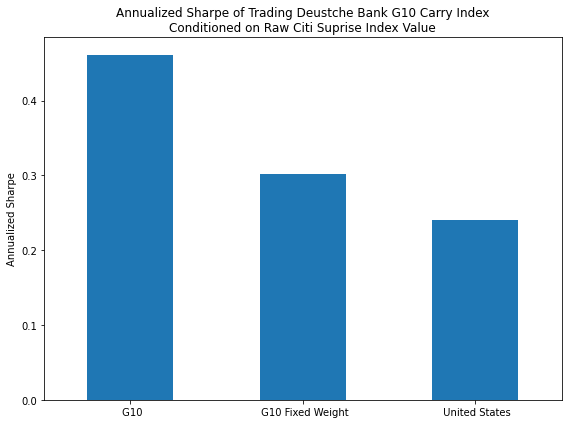

In [7]:
def plot_sharpe(df_signal: pd.DataFrame) -> plt.Figure: 

    (df_signal.drop(
        columns = ["date"]).
        groupby("desc").
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn", 
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        plot(
            kind    = "bar",
            legend  = False,
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            figsize = (8,6),
            rot     =  0,
            title   = "Annualized Sharpe of Trading Deustche Bank G10 Carry Index\nConditioned on Raw Citi Suprise Index Value"))

    plt.tight_layout()

plot_sharpe(df_signal)

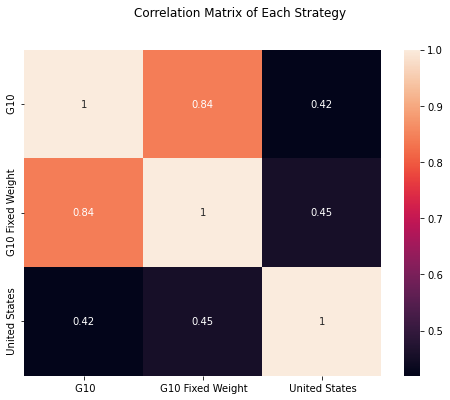

In [8]:
def plot_correlation_matrix(df_signal: pd.DataFrame) -> plt.Figure: 

    df_corr = (df_signal.pivot(
        index = "date", columns = "desc", values = "signal_rtn").
        corr())
    
    fig, axes = plt.subplots(figsize = (8,6))
    sns.heatmap(
        data  = df_corr,
        ax    = axes,
        annot = True)
    
    axes.set_xlabel(""); axes.set_ylabel("")
    fig.suptitle("Correlation Matrix of Each Strategy")

plot_correlation_matrix(df_signal)

## Portfolio Optimization

In [9]:
def get_erc(df_signal: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_vol = (df_signal.pivot(
        index = "date", columns = "desc", values = "signal_rtn").
        ewm(span = window, adjust = False).
        std().
        shift().
        apply(lambda x: 1 / x).
        reset_index().
        melt(id_vars = "date").
        rename(columns = {"value": "inv_vol"}).
        dropna())
    
    df_out = (df_vol.drop(
        columns = ["desc"]).
        groupby("date").
        agg("sum").
        rename(columns = {"inv_vol": "cum_vol"}).
        merge(right = df_vol, how = "inner", on = ["date"]).
        merge(right = df_signal, how = "inner", on = ["date", "desc"]).
        assign(weighted_rtn = lambda x: x.inv_vol / x.cum_vol * x.signal_rtn))

    return df_out

df_erc = get_erc(df_signal)

In [10]:
def get_port(df_signal: pd.DataFrame, df_erc: pd.DataFrame) -> pd.DataFrame: 

    df_mean = (df_signal.drop(
        columns = "desc").
        groupby("date").
        agg("mean").
        rename(columns = {"signal_rtn": "mean_rtn"}))
    
    df_erc_combined = (df_erc[
        ["date", "weighted_rtn"]].
        groupby("date").
        agg("sum").
        rename(columns = {"weighted_rtn": "erc_rtn"}))
    
    df_combined = (df_mean.merge(
        right = df_erc_combined, how = "inner", on = ["date"]))

    return df_combined

df_port = get_port(df_signal, df_erc)

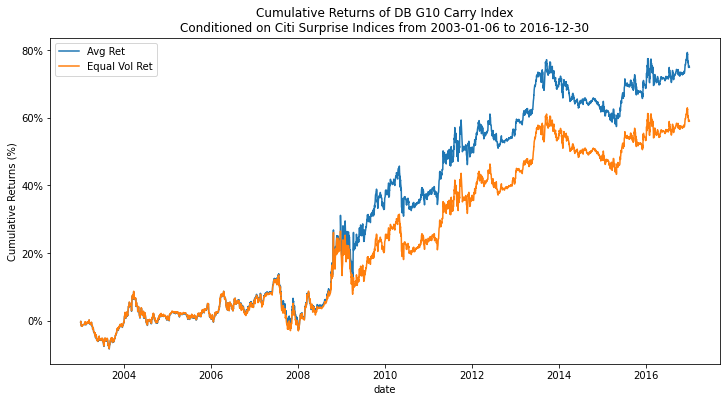

In [11]:
def plot_port(df_port: pd.DataFrame) -> plt.Figure: 

    fig, axes = plt.subplots(figsize = (12,6))
    
    (df_port.rename(
        columns = {
            "mean_rtn": "Avg Ret",
            "erc_rtn" : "Equal Vol Ret"}).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ylabel = "Cumulative Returns (%)",
            ax     = axes,
            title  = "Cumulative Returns of DB G10 Carry Index\nConditioned on Citi Surprise Indices from {} to {}".format(
                df_port.index.min(),
                df_port.index.max())))
    
    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

plot_port(df_port)

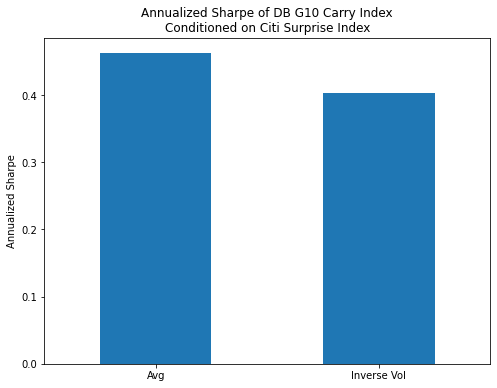

In [12]:
def plot_port_sharpe(df_port: pd.DataFrame) -> plt.Figure: 

    (df_port.reset_index().melt(
        id_vars = "date").
        drop(columns = ["date"]).
        assign(variable = lambda x: x.variable.str.split("_").str[0]).
        assign(variable = lambda x: np.where(x.variable == "erc", "Inverse Vol", "Avg")).
        groupby("variable").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn", 
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        plot(
            kind    = "bar",
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            legend  = False,
            figsize = (8,6),
            rot     = 0,
            title   = "Annualized Sharpe of DB G10 Carry Index\nConditioned on Citi Surprise Index"))

plot_port_sharpe(df_port)

## Performance of all Citi Indicators

In [13]:
def get_citi() -> pd.DataFrame: 
    
    df_raw = FXData().get_citi_suprise()

    securities = (df_raw.drop(
        columns = ["value"]).
        groupby("security").
        agg(["min", "max", "count"])
        ["date"].
        query("count > 500").
        index.
        to_list())

    df_out = df_raw.query("security == @securities")
    
    return df_out

df_citi = get_citi()

In [14]:
def get_carry() -> pd.DataFrame:
    
    keep_cols = ["FXCARRSP"]

    df_out = (FXData().get_misc_indices().query(
        "security == @keep_cols").
        pivot(index = "date", columns = "security", values = "rtn"))
    
    return df_out

df_carry = get_carry()

In [15]:
def get_all_signal(df_citi: pd.DataFrame, df_carry: pd.DataFrame) -> pd.DataFrame: 
    
    df_signal = (df_citi.pivot(
        index = "date", columns = "security", values = "value").
        shift().
        apply(lambda x: np.sign(x)).
        reset_index().
        melt(id_vars = "date").
        dropna().
        merge(right = df_carry, how = "inner", on = ["date"]).
        assign(signal_rtn = lambda x: np.sign(x.value) * x.FXCARRSP))
    
    return df_signal

df_signal = get_all_signal(df_citi, df_carry)

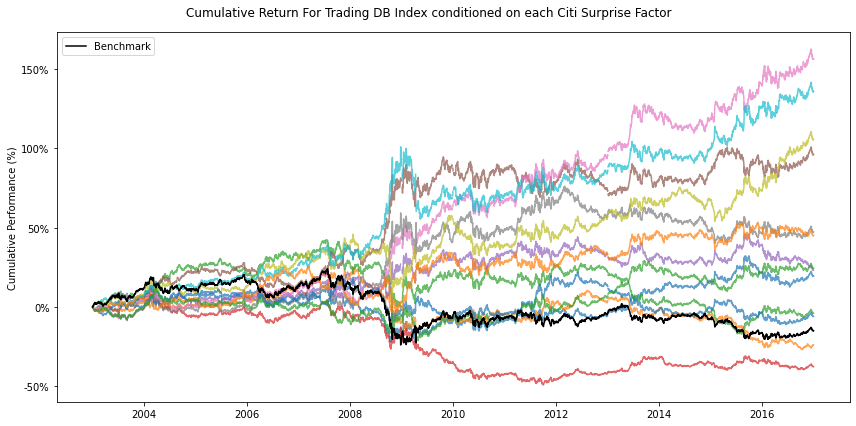

In [16]:
def plot_citi_performance(df_signal: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_signal.pivot(
        index = "date", columns = "security", values = "signal_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            legend = False,
            ax     = axes,
            alpha  = 0.7))

    (df_signal.set_index(
        "date")
        [["FXCARRSP"]].
        rename(columns = {"FXCARRSP": "Benchmark"}).
        drop_duplicates().
        sort_index().
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            xlabel = "",
            ylabel = "Cumulative Performance (%)",
            ax     = axes,
            color  = "black"))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    fig.suptitle("Cumulative Return For Trading DB Index conditioned on each Citi Surprise Factor")
    plt.tight_layout()
    
plot_citi_performance(df_signal)

In [17]:
def get_mean_median(df_signal: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_signal.drop(
        columns = ["security", "value"]).
        groupby(["date", "FXCARRSP"]).
        agg(["mean", "median"])
        ["signal_rtn"].
        reset_index().
        set_index("date").
        rename(columns = {
            "mean"  : "MeanPort",
            "median": "MedianPort"}))
    
    return df_out

df_mean_median = get_mean_median(df_signal)

In [18]:
def get_mean_median_sharpe(df_mean_median: pd.DataFrame) -> pd.DataFrame:
    
    df_sharpe = (df_mean_median.reset_index().melt(
        id_vars = "date").
        drop(columns = ["date"]).
        groupby("variable").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))
    
    return df_sharpe

df_mean_median_sharpe = get_mean_median_sharpe(df_mean_median)

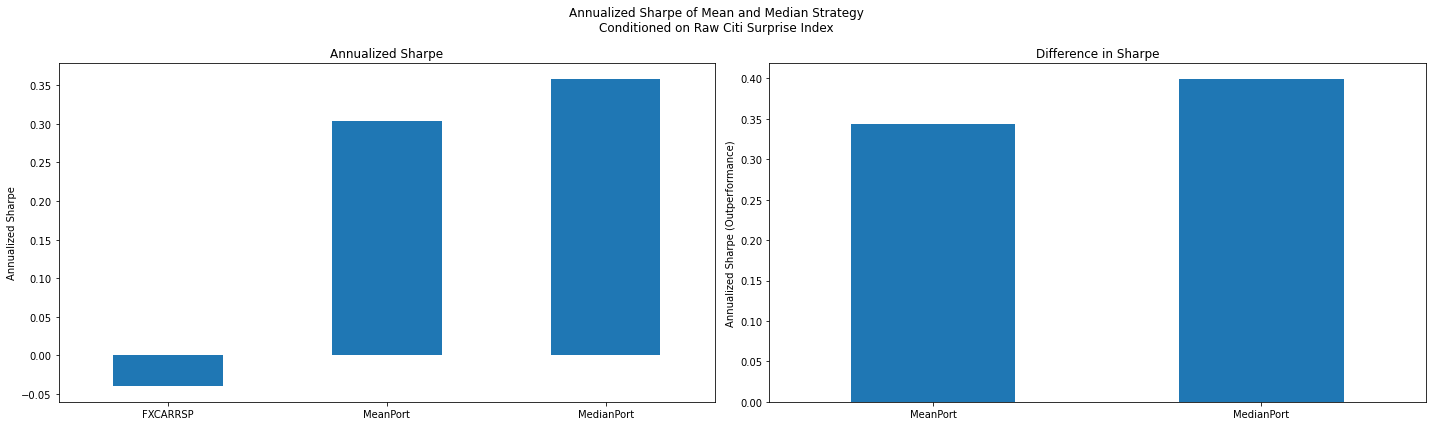

In [19]:
def plot_mean_median_sharpe(df_mean_median_sharpe: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_mean_median_sharpe[[
        "sharpe"]].
        T.
        reset_index(drop = True).
        melt(id_vars = ["FXCARRSP"]).
        assign(sharpe_spread = lambda x: x.value - x.FXCARRSP).
        set_index("variable")
        [["sharpe_spread"]].
        plot(
            legend = False,
            kind   = "bar",
            ax     = axes[1],
            title  = "Difference in Sharpe",
            rot    = 0,
            xlabel = "",
            ylabel = "Annualized Sharpe (Outperformance)"))

    (df_mean_median_sharpe[
        ["sharpe"]].
        plot(
            kind   = "bar",
            ax     = axes[0],
            legend = False,
            rot    = 0,
            xlabel = "",
            ylabel = "Annualized Sharpe",
            title  = "Annualized Sharpe"))

    fig.suptitle("Annualized Sharpe of Mean and Median Strategy\nConditioned on Raw Citi Surprise Index")
    plt.tight_layout()
    
plot_mean_median_sharpe(df_mean_median_sharpe)

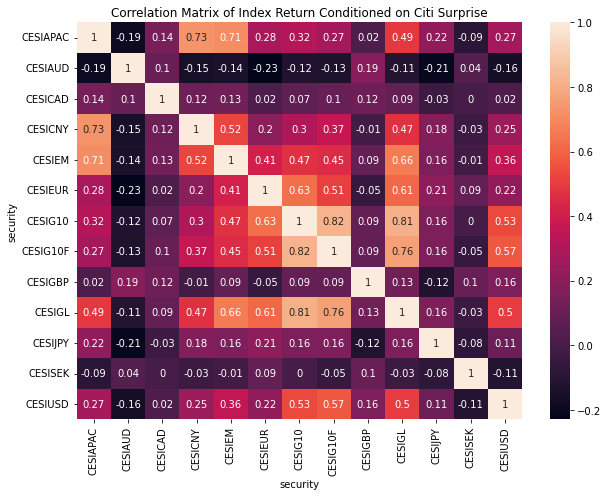

In [20]:
def plot_correlation_matrix() -> plt.Figure:
    
    fig, axes = plt.subplots(figsize = (9,7))

    df_corr = (df_signal.pivot(
        index = "date", columns = "security", values = "signal_rtn").
        corr().
        apply(lambda x: np.round(x, 2)))

    sns.heatmap(
        data  = df_corr,
        ax    = axes,
        annot = True)

    axes.set_title("Correlation Matrix of Index Return Conditioned on Citi Surprise")
    plt.tight_layout()
    
plot_correlation_matrix()

In [21]:
def get_sharpe(df_signal: pd.DataFrame) -> plt.Figure: 
    
    df_sharpe = (df_signal.drop(
        columns = ["value"]).
        rename(columns = {"FXCARRSP": "Benchmark"}).
        pivot(index = ["date", "Benchmark"], columns = "security", values = "signal_rtn").
        reset_index().
        melt(id_vars = "date").
        drop(columns = ["date"]).
        groupby("security").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)))
    
    return df_sharpe

df_sharpe = get_sharpe(df_signal)

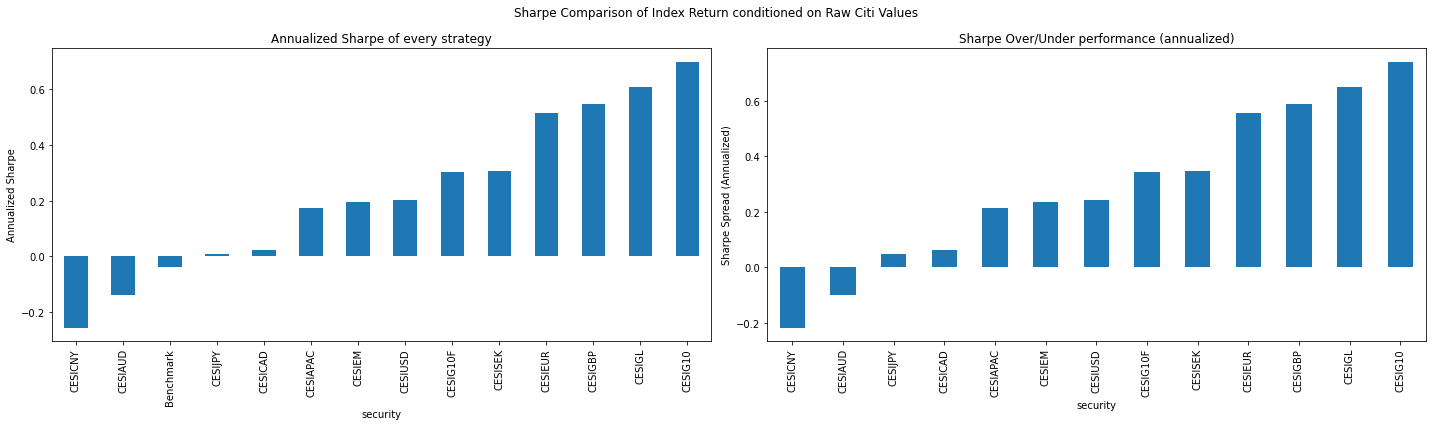

In [22]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    (df_sharpe[
        ["sharpe"]].
        sort_values("sharpe").
        plot(
            kind   = "bar",
            ax     = axes[0],
            legend = False,
            ylabel = "Annualized Sharpe",
            title  = "Annualized Sharpe of every strategy"))

    (df_sharpe[
        ["sharpe"]].
        T.
        melt(id_vars = "Benchmark").
        assign(spread = lambda x: x.value - x.Benchmark).
        set_index("security")
        [["spread"]].
        sort_values("spread").
        plot(
            kind   = "bar",
            ax     = axes[1],
            legend = False,
            ylabel = "Sharpe Spread (Annualized)",
            title  = "Sharpe Over/Under performance (annualized)"))

    fig.suptitle("Sharpe Comparison of Index Return conditioned on Raw Citi Values")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)

In [23]:
def get_avg(df_signal: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df_signal.pivot(
        index = "date", columns = "security", values = "signal_rtn").
        mean(axis = 1).
        to_frame(name = "avg_rtn"))
    
    return df_out

df_avg = get_avg(df_signal)

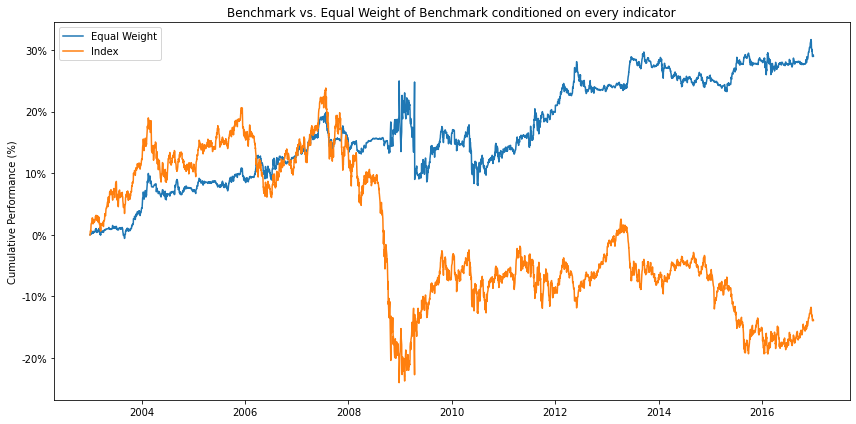

In [24]:
def plot_avg_performance(df_avg: pd.DataFrame, df_carry: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_avg.merge(
        right = df_carry, how = "inner", on = ["date"]).
        rename(columns = {
            "avg_rtn" : "Equal Weight",
            "FXCARRSP": "Index"}).
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax     = axes,
            ylabel = "Cumulative Performance (%)",
            xlabel = "",
            title  = "Benchmark vs. Equal Weight of Benchmark conditioned on every indicator"))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    plt.tight_layout()
    
plot_avg_performance(df_avg, df_carry)

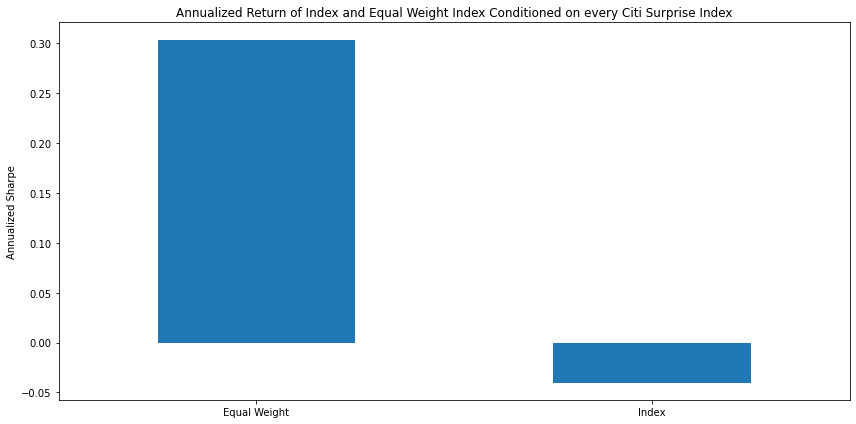

In [25]:
def plot_sharpe(df_avg: pd.DataFrame, df_carry: pd.DataFrame) -> plt.Figure: 
    
    (df_avg.merge(
        right = df_carry, how = "inner", on = ["date"]).
        rename(columns = {
            "avg_rtn" : "Equal Weight",
            "FXCARRSP": "Index"}).
        reset_index().
        melt(id_vars = "date").
        drop(columns = ["date"]).
        groupby("variable").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        plot(
            kind = "bar",
            xlabel = "",
            rot  = 0,
            legend = False,
            ylabel = "Annualized Sharpe",
            figsize = (12,6),
            title   = "Annualized Return of Index and Equal Weight Index Conditioned on every Citi Surprise Index"))

    plt.tight_layout()
    
plot_sharpe(df_avg, df_carry)